In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from plenoptic.simulate.frontend import Front_End
from plenoptic.simulate.steerable_pyramid_freq import Steerable_Pyramid_Freq
from plenoptic.simulate.non_linearities import local_gain_control

In [3]:
def steer(pyr_coeffs, residuals=True):

    S = np.max(np.array([k for k in pyr_coeffs.keys() if isinstance(k, tuple)])[:, 0]) + 1

    pyr_coeffs_steered = {}

    for s in range(S):
        pyr_coeffs_steered[s, 0] = pyr_coeffs[s, 0]
        pyr_coeffs_steered[s, 1] = (pyr_coeffs[s, 0] + pyr_coeffs[s, 1]) / np.sqrt(2)
        pyr_coeffs_steered[s, 2] = pyr_coeffs[s, 1]
        pyr_coeffs_steered[s, 3] = (pyr_coeffs[s, 1] - pyr_coeffs[s, 0]) / np.sqrt(2)
    

    if residuals:
        pyr_coeffs_steered['residual_lowpass'] = pyr_coeffs['residual_lowpass']
        pyr_coeffs_steered['residual_highpass'] = pyr_coeffs['residual_highpass']

    return pyr_coeffs_steered

In [4]:
def standardize(X, epsilon=1e-16):
    return (X - torch.mean(X)) / (torch.std(X) + epsilon)

def global_gain_control(coeffs):
    
    coeffs_normalized = {}
    for k in coeffs.keys():
        coeffs_normalized[k] = standardize(coeffs[k])

    return coeffs_normalized    

In [5]:
def ori_diff(coeffs):

    S = np.max(np.array([k for k in coeffs.keys() if isinstance(k, tuple)])[:, 0]) + 1
    B = np.max(np.array([k for k in coeffs.keys() if isinstance(k, tuple)])[:, 1]) + 1
    
    oridiff = {}
    for s in range(S):
        for b in range(B):
            oridiff[s,b] = coeffs[s, (b+1) % 4] - coeffs[s, b]

    return oridiff

In [6]:
def scale_diff(coeff):
    S = np.max(np.array([k for k in coeff.keys() if isinstance(k, tuple)])[:, 0]) + 1
    B = np.max(np.array([k for k in coeff.keys() if isinstance(k, tuple)])[:, 1]) + 1

    scalediff = {}
    j = 0
    for s in range(1, S):
        for b in range(B):
            fine = coeff[s-1, b] #standardize(coeff[s-1, b])
            coarse = po.upsample_blur(coeff[s, b]) #standardize(po.upsample_blur(coeff[s, b]))
            scalediff[j, b] = (fine - coarse) / np.sqrt(2)
#             scalediff[j+1, b] = (fine + coarse) / np.sqrt(2)
#         j += 2
        j += 1
        
    return scalediff

In [24]:
class V2(nn.Module):
    """


    """
    def __init__(self, frontend=False, steer=False):
        super(V2, self).__init__()

        self.frontend = frontend
        if self.frontend:
            self.F = Front_End()
            
        self.steer = steer
        if self.steer:
            self.L1 = Steerable_Pyramid_Freq([256, 256], order=1, height=5, is_complex=False)
        else:
            self.L1 = Steerable_Pyramid_Freq([256, 256], order=3, height=5, is_complex=False)
        
        self.L2 = ori_diff
        self.L3 = scale_diff
        
        self.GG = global_gain_control
        self.LG = local_gain_control
        
    def forward(self, x):

        if self.frontend:
            x = self.F(x)
        
        if self.steer:
            self.activation1 = steer(self.L1(x))
        else:
            self.activation1 = self.L1(x)
        
        self.activation_standard = self.GG(self.activation1)
        self.energy1, self.state1 = self.LG(self.activation_standard, (2, 2))

        o = self.GG(self.L2(self.energy1))
        s = self.GG(self.L3(self.energy1))
#         o = self.GG(self.L2(self.state1))
#         s = self.GG(self.L3(self.state1))

        energy2, state2 = self.LG(o, residuals=False)
        energy3, state3 = self.LG(s, residuals=False)

        return [k for k in self.energy1.values()] + [k for k in energy2.values()] + [k for k in energy3.values()]
#         return [k for k in state1.values()] + [k for k in state2.values()] + [k for k in state3.values()]

#         return [k for k in energy2.values()] + [k for k in energy3.values()]

In [25]:
v2 = V2()

In [26]:
stimuli = po.make_basic_stimuli()
# pt.imshow(numpy(stimuli));

In [27]:
y = v2.forward(stimuli)

In [28]:
v2.activation1[0, 3].shape

torch.Size([15, 1, 256, 256])

In [29]:
len(y)

58

In [30]:
y[0].shape

torch.Size([15, 1, 128, 128])

In [31]:
[y[i][-3].shape for i in range(len(y))]

[torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 32, 32]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 4, 4

In [32]:
m = po.synth.Metamer(stimuli[-3].unsqueeze(0), v2)

In [33]:
try:
    init = m_im.unsqueeze(0).unsqueeze(0)
except NameError:
    print('init')
    init = None
m_im, m_rep = m.synthesize(initial_image=init, learning_rate=1, save_image=10)


  0%|          | 0/100 [00:00<?, ?it/s]

init



 73%|███████▎  | 73/100 [00:36<00:14,  1.93it/s, gradient_norm=3.0045e-01, learning_rate=1, loss=6.1090e+01]


100%|██████████| 100/100 [00:49<00:00,  2.00it/s, gradient_norm=2.2738e-01, learning_rate=1, loss=5.2272e+01]

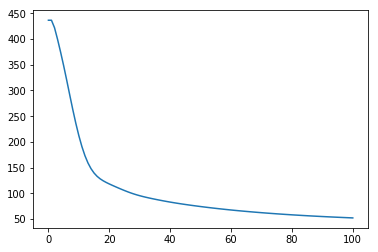

In [34]:
plt.plot(m.loss)

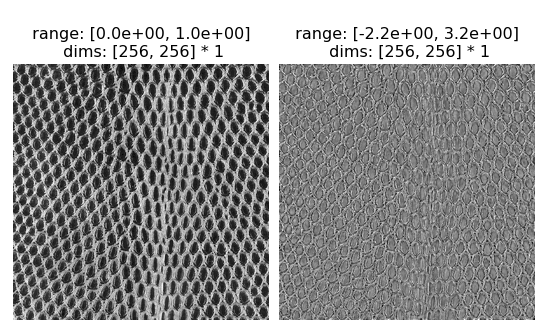

In [37]:
pt.imshow([numpy(m.target_image), numpy(m.matched_image)]);

In [36]:
# animation
# pt.animshow(numpy(m.saved_image))

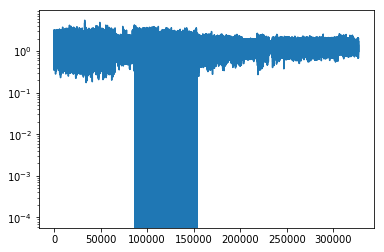

In [37]:
plt.semilogy(numpy(m.target_representation));

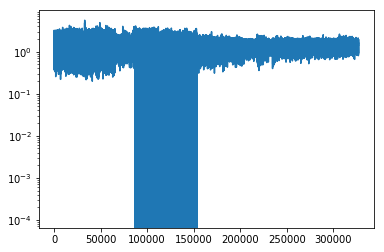

In [38]:
plt.semilogy(numpy(m.matched_representation));

In [12]:
spatial_channel_local_blurr = nn.Conv3d(1, 1, (7, 5, 5), stride=(2,2,2))

In [13]:
k = (3, 5, 5)
p = (1, 2, 2)
m = nn.AvgPool3d(kernel_size=k, stride=(1,1,1), padding=p, count_include_pad=False)

In [14]:
s = 0
a = torch.cat([v2.energy1[s, b] for b in range(4)], dim=1)

In [15]:
epsilon = 1e-12
denom = m( a.unsqueeze(1) ** 2) ** .5
b = a / (denom.squeeze(1) ) # max(meandenom, denom)

In [16]:
# Local Contrast Normalization 2009
# What is the Best Multi-Stage Architecture for Object Recognition
# Jarrett
# mean substract
# stabilize division using a max

# Local Response Normalization
# ImageNet Classification with Deep ConvolutionalNeural Networks
# Krizhevsky
# no mean sub (lateral inhibition)
# divide by (1 + 1e-4 * sum sq)**.75

# generalized divisive normalization
# Balle
# y[i] = x[i] / sqrt(beta[i] + sum_j(gamma[j, i] * x[j]))
# https://github.com/jorge-pessoa/pytorch-gdn/blob/master/pytorch_gdn/__init__.py

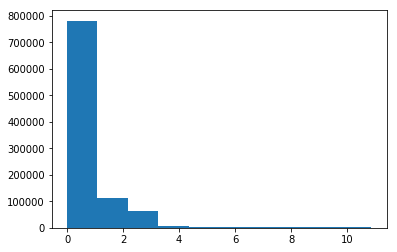

In [17]:
plt.hist(numpy(denom).flatten());

In [18]:
b.shape

torch.Size([15, 4, 128, 128])

In [12]:
# space orientation gain control

energy = {}
state = {}

for key in coeff_dict.keys():
    if isinstance(key, tuple):
        energy[key], state[key] = ...(coeff_dict[key], step=step)

if residuals:
    energy['residual_lowpass'] = coeff_dict['residual_lowpass']
    energy['residual_highpass'] = coeff_dict['residual_highpass']

    return energy, state


NameError: name 'coeff_dict' is not defined

In [53]:
t = torch.cat([po.blur_downsample(v2.activation1[0, b]) for b in range(4)], dim=1).unsqueeze(1)

In [43]:
f = torch.tensor(pt.named_filter('binom5').squeeze())

In [45]:
filt = torch.einsum('i, j, k -> ijk', (f, f, f))

In [54]:
torch.roll(f)

tensor([0.0884, 0.0884, 0.3536, 0.5303, 0.3536], dtype=torch.float64)

In [27]:
#channel whitening

In [28]:
v2.activation1[0, 0].shape

torch.Size([15, 1, 256, 256])

In [39]:
G = []
for s in range(4):

    a = torch.cat([v2.energy1[s, b][-1].unsqueeze(0) for b in range(4)], dim=1)
    N = a.shape[-1] * a.shape[-2]
    g = torch.einsum('bchw, bdhw -> bcd', (a,a)) / N
    print(torch.symeig(g[0], eigenvectors=True))
    G.append(g)

G = torch.cat(G)

torch.return_types.symeig(
eigenvalues=tensor([0.0564, 0.2641, 0.3553, 7.3157], grad_fn=<SymeigBackward>),
eigenvectors=tensor([[ 0.5456, -0.4773, -0.4718,  0.5020],
        [-0.5194, -0.5190,  0.4577,  0.5013],
        [ 0.4519,  0.5056,  0.5408,  0.4978],
        [-0.4778,  0.4973, -0.5249,  0.4989]], grad_fn=<SymeigBackward>))
torch.return_types.symeig(
eigenvalues=tensor([0.0562, 0.1431, 0.2080, 7.5842], grad_fn=<SymeigBackward>),
eigenvectors=tensor([[-0.5985, -0.3441,  0.5219,  0.5011],
        [ 0.5337, -0.6201, -0.2794,  0.5026],
        [-0.3910,  0.3721, -0.6798,  0.4965],
        [ 0.4518,  0.5988,  0.4330,  0.4998]], grad_fn=<SymeigBackward>))
torch.return_types.symeig(
eigenvalues=tensor([0.0505, 0.0780, 0.1267, 7.7353], grad_fn=<SymeigBackward>),
eigenvectors=tensor([[-0.7487,  0.0518, -0.4295,  0.5022],
        [ 0.4010,  0.7656, -0.0189,  0.5027],
        [-0.1572, -0.2220,  0.8255,  0.4945],
        [ 0.5039, -0.6015, -0.3656,  0.5006]], grad_fn=<SymeigBackward>))
torc

In [126]:
t = torch.randn(10,5,256,256)

In [128]:
a,b=po.simul.non_linearities.real_rectangular_to_polar(t)

In [130]:
a.shape, b.shape

(torch.Size([10, 5, 128, 128]), torch.Size([10, 5, 256, 256]))

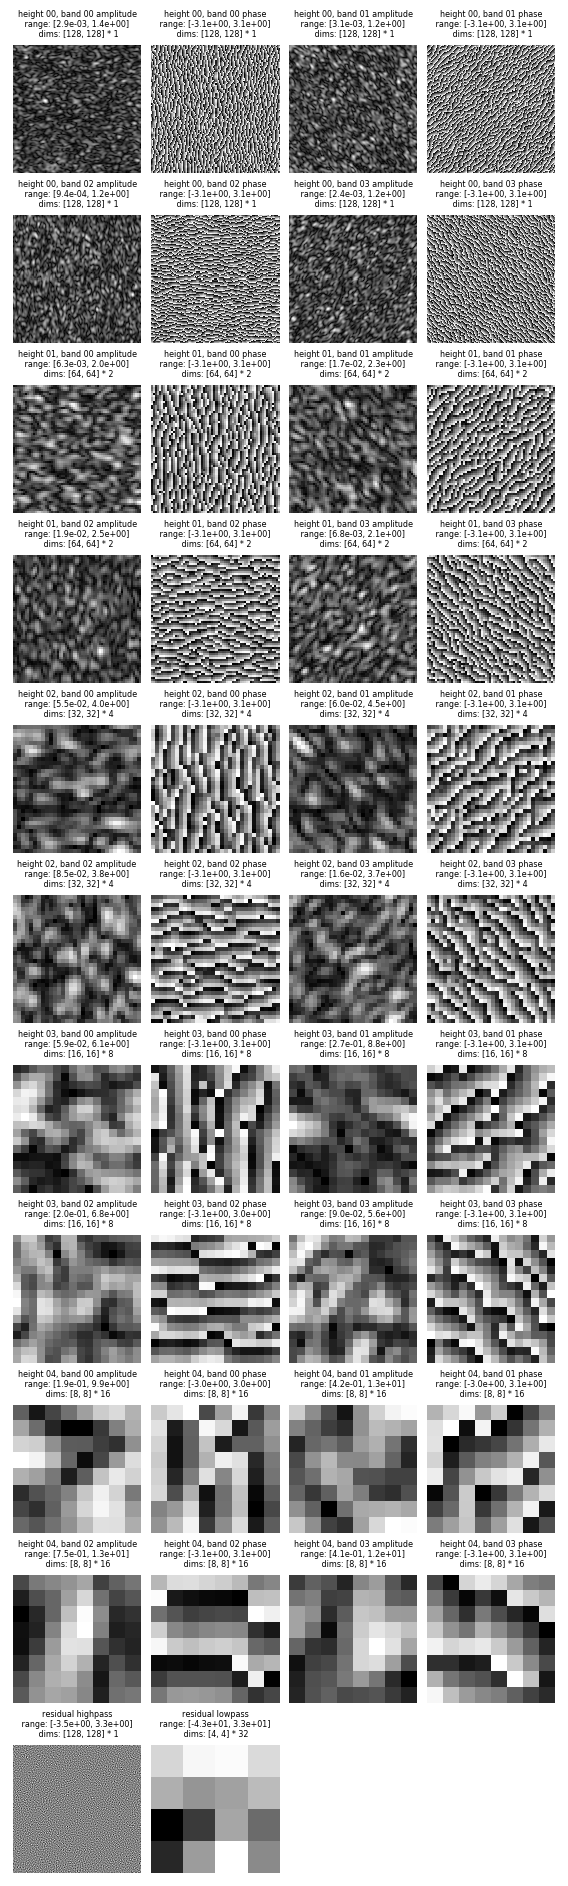

In [122]:
pt.pyrshow(pt.pyramids.SteerablePyramidFreq(np.random.randn(128,128), is_complex=True).pyr_coeffs, plot_complex='polar');